In [2]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from datetime import datetime,timedelta
from collections import Counter
from matplotlib.pyplot import hot
from sqlalchemy import column
from matplotlib.pyplot import legend
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['font.sans-serif'] = ['Times New Roman']

In [19]:
road = geopandas.read_file("./road_network/topo_centerroad.shp")
park = geopandas.read_file("./road_network/park_new.shp")
park_list = list(park.zone_id)

In [20]:
def riqi_ftime(df):
    df.insert(1,'riqi',df.ftime.map(lambda x: x.split(' ')[0]))
    df.insert(2,'fftime',df.ftime.map(lambda x: x.split(' ')[1]))
    df.drop('ftime',axis=1,inplace=True)
    return df

def park_hotness(in_df):
    park_dict = dict(Counter(in_df.tpark))
    park_dict =  {k:park_dict[k] if k in park_dict else 0 for k in park_list}
    value_list = list(park_dict.values())
    value_list.sort(reverse=True)
    top5 = value_list[int(len(value_list)*0.05)]
    top10 = value_list[int(len(value_list)*0.1)]
    top15 = value_list[int(len(value_list)*0.15)]
    top25 = value_list[int(len(value_list)*0.25)]
    top50 = value_list[int(len(value_list)*0.5)]
    for i in list(park_dict.keys()):
        if park_dict[i]>=top5:
            park_dict[i]='Top- 5%'
        elif park_dict[i]>=top10:
            park_dict[i]='Top-10%'
        elif park_dict[i]>=top15:
            park_dict[i]='Top-15%'
        elif park_dict[i]>=top25:
            park_dict[i]='Top-25%'
        elif park_dict[i]>=top50:
            park_dict[i]='Top-50%'
        else:
            park_dict[i]='the others'
    return park_dict

def park_hotness_value(in_df):
    park_dict = dict(Counter(in_df.tpark))
    park_dict =  {k:park_dict[k] if k in park_dict else 0 for k in park_list}
    return park_dict

In [21]:
trip_df = pd.read_csv("./data/generate_tq_path_tt.csv",encoding='utf-8')
trip_df = riqi_ftime(trip_df)
trip_df = trip_df.query("'2019-08-12'<=riqi<='2019-08-18'") 

## Hotness of traffic zones

In [22]:
park_dict = park_hotness(trip_df)
park_dict_value = park_hotness_value(trip_df)

In [23]:
park.insert(1,'hotness_level',park.zone_id.map(lambda x:park_dict[x]))
park.insert(2,'hotness',park.zone_id.map(lambda x:park_dict_value[x]))
sort_dict = {'Top- 5%':1,'Top-10%':2,'Top-15%':3,'Top-25%':4,'Top-50%':5,'the others':6}
park.insert(3,'hotness_rank',park.hotness_level.map(lambda x:sort_dict[x]))
hotness_max = park.hotness.max()
park.insert(4,'dot_size',park.hotness.map(lambda x:int(60+440*(x/hotness_max))))

In [24]:
park.sort_values(by='hotness_rank', inplace=True)

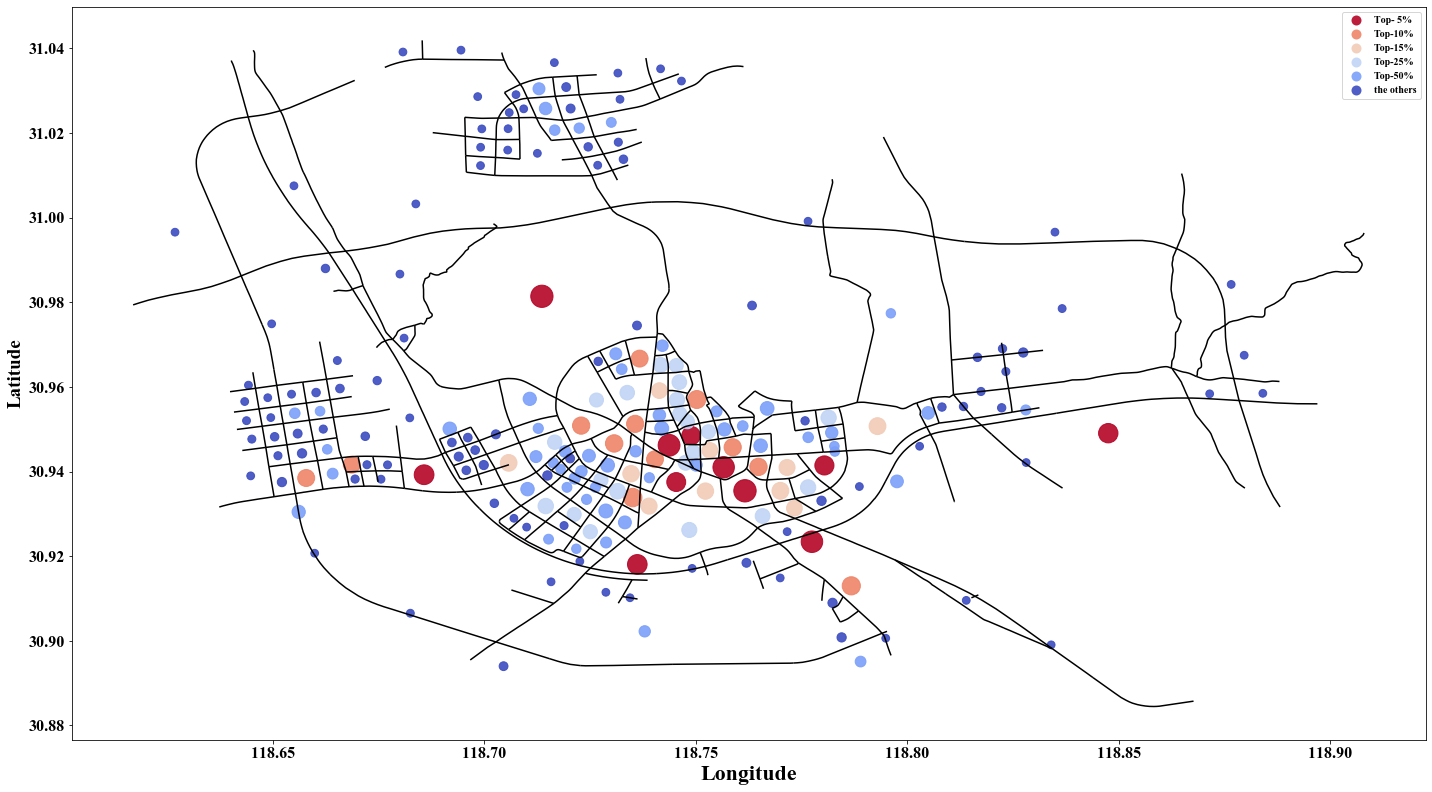

In [25]:
fig,ax = plt.subplots(1,1,figsize = (20,20))

plt.xticks(fontproperties='Times New Roman', size=16)
plt.yticks(fontproperties='Times New Roman', size=16)
ax.set_ylabel('Latitude', fontproperties='Times New Roman',size=19)
ax.set_xlabel('Longitude', fontproperties='Times New Roman',size=22)
divider = make_axes_locatable(ax)
# cax.set_yticklabels({'fontsize': 18})
road.plot(ax=ax,color = 'black')
park.plot(ax=ax,column='hotness_level', markersize = list(park.dot_size), cmap='coolwarm_r',alpha=0.9,legend=True)

plt.tight_layout()
# plt.savefig("./fig/spa_hotness_glc_h.pdf")

         

## Road access frequency

In [26]:
road_list = [str(int(i)) for i in list(road.objectid)]

In [27]:
trip_df.loc[:,'path']=trip_df.path.map(lambda x:x.split('-'))

In [28]:
flow_list = []
flow_list_g = []
for row in trip_df.path:
    flow_list.extend(row)
counter_flow=Counter(flow_list)
dict_flow = dict(counter_flow)
top_flow_dict = {k:int(dict_flow[k]/7) if k in dict_flow else 0 for k in road_list}

for row in trip_df.path:
    flow_list_g.extend(row)
counter_flow_g=Counter(flow_list_g)
dict_flow_g = dict(counter_flow_g)
top_flow_g_dict = {k:int(dict_flow[k]/7) if k in dict_flow else 0 for k in road_list}

In [29]:
road = geopandas.read_file("./road_network/topo_centerroad.shp")
road.insert(1,'flow',road.objectid.map(lambda x:top_flow_dict[str(int(x))]))
flow_max = road.flow.max()
road.insert(2,'line_size', road.flow.map(lambda x:round((2.5+3*(x/flow_max)),1)))

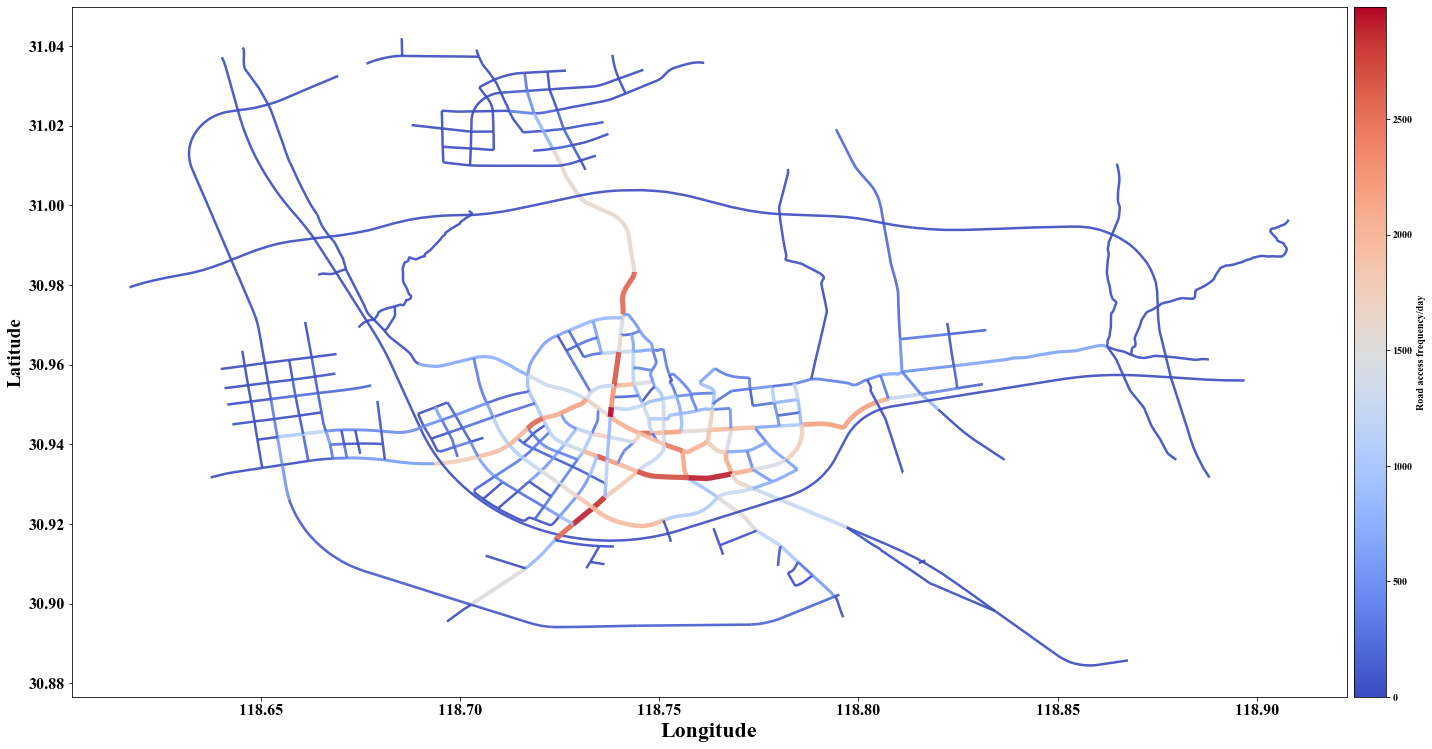

In [30]:
fig,ax = plt.subplots(1,1,figsize = (20,20))

plt.xticks(fontproperties='Times New Roman', size=16)
plt.yticks(fontproperties='Times New Roman', size=16)
ax.set_ylabel('Latitude', fontproperties='Times New Roman',size=19)
ax.set_xlabel('Longitude', fontproperties='Times New Roman',size=22)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.1)
road.plot(ax=ax, column = 'flow', linewidth = list(road.line_size), cmap='coolwarm',alpha=0.9,legend=True,cax=cax, 
          legend_kwds={'label': "Road access frequency/day"})
plt.tight_layout()
# plt.savefig("./fig/spa_flow_gp_h.pdf")
